In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# make Numpy printouts easier to read
np.set_printoptions(precision=3,suppress=True)

In [2]:
# importing files
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Get the data online
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders','Displacement', 'Horsepower','Weight','Acceleration','Model Year','Origin']
df = pd.read_csv(url, names = column_names, na_values = '?', comment = '\t', sep = ' ', skipinitialspace = True)

In [4]:
# clean the data
df.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
# drops the null values if any
df=df.dropna()

In [6]:
df['Origin'] = df['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [7]:
df = pd.get_dummies(df, columns=['Origin'], prefix='', prefix_sep='')
df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [8]:
#dividing train and test folders
train = df.sample(frac=0.8, random_state=0)
test = df.drop(train.index)

In [9]:
train_features=train.copy()
test_features=test.copy()
train_labels=train_features.pop('MPG')
test_labels=test_features.pop('MPG')

In [10]:
# normalization
train.describe().transpose()[['mean','std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [11]:
normalizer=tf.keras.layers.Normalization(axis=-1)

In [12]:
normalizer.adapt(np.array(train_features))

In [13]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [14]:
first=np.array(train_features[:1])

In [15]:
with np.printoptions(precision=2,suppress=True):
    print('First example :',first)
    print('Normalized: ',normalizer(first).numpy())

First example : [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]
Normalized:  [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [16]:
horsepower = np.array(train_features['Horsepower'])
horsepower_normalizer = layers.Normalization(input_shape=[1,],axis = None)
horsepower_normalizer.adapt(horsepower)

In [17]:
# Build The keras model
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])
horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [18]:
horsepower_model.predict(horsepower[:10])

array([[-0.29 ],
       [-0.164],
       [ 0.536],
       [-0.407],
       [-0.368],
       [-0.145],
       [-0.436],
       [-0.368],
       [-0.096],
       [-0.164]], dtype=float32)

In [19]:
# compilation
horsepower_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),loss='mean_absolute_error')

In [20]:
%%time
history=horsepower_model.fit( train_features['Horsepower'],train_labels,epochs=100,#supress logging.
                            verbose=0,
                            #calculate validation result on 20% train data.
                            validation_split=0.2)


Wall time: 3.11 s


In [21]:
# visualising the model
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804566,4.188996,95
96,3.801862,4.194817,96
97,3.803380,4.212723,97
98,3.808367,4.210137,98
99,3.802323,4.178982,99


In [22]:
def plot_loss(history):
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.ylim([0,10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

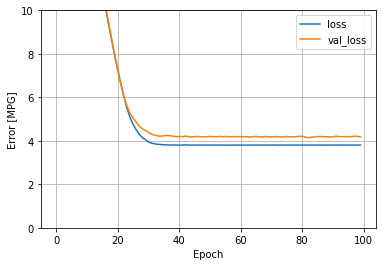

In [23]:
plot_loss(history)

In [24]:
test_results={}
test_results['horsepower_model']=horsepower_model.evaluate(test_features['Horsepower'],test_labels,verbose=0)

In [25]:
x=tf.linspace(0.0,250,251)
y=horsepower_model.predict(x)

In [26]:
def plot_horsepower(X,y):
    plt.scatter(train_features['Horsepower'],train_labels,label='Data')
    plt.plot(X,y,label='Predictions')
    plt.xlabel('HorsePower')
    plt.ylabel('MPG')
    plt.legend()

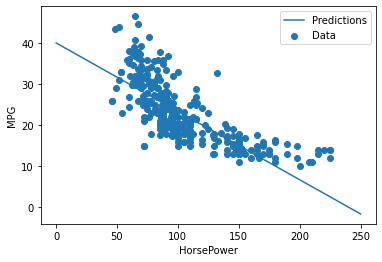

In [27]:
plot_horsepower(x,y)

In [28]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [29]:
linear_model.predict(train_features[:10])

array([[ 0.002],
       [ 0.098],
       [ 0.971],
       [-1.079],
       [-1.195],
       [ 0.613],
       [-1.028],
       [ 0.635],
       [ 0.93 ],
       [ 0.036]], dtype=float32)

In [30]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.085],
       [ 0.271],
       [-0.17 ],
       [ 0.145],
       [ 0.651],
       [-0.56 ],
       [-0.155],
       [-0.41 ],
       [ 0.062]], dtype=float32)>

In [31]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [32]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Wall time: 5.51 s


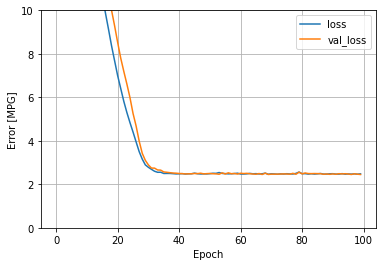

In [33]:
plot_loss(history)

In [34]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64,activation='relu'),
        layers.Dense(64,activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model


In [35]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [36]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [37]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100)

Wall time: 4.89 s


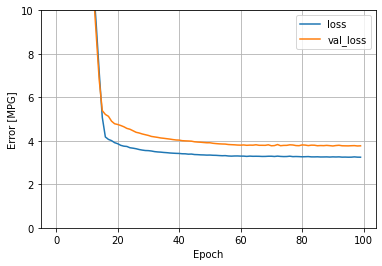

In [38]:
plot_loss(history)

In [39]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

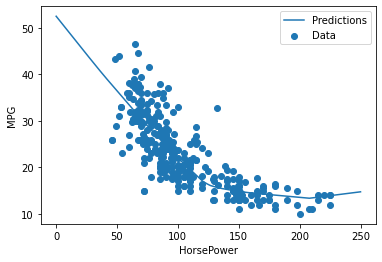

In [40]:
plot_horsepower(x, y)

In [41]:
test_results['dnn_horsepower_model']=dnn_horsepower_model.evaluate(
test_features['Horsepower'],test_labels,verbose=0)

In [42]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [43]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 6.19 s


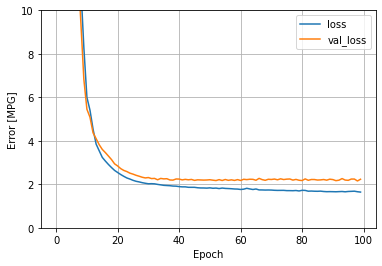

In [44]:
plot_loss(history)

In [45]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [46]:
weights = dnn_model.get_weights()

In [47]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.645762
dnn_horsepower_model,2.896573
dnn_model,1.676419


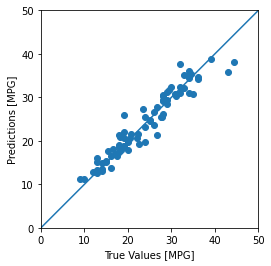

In [48]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

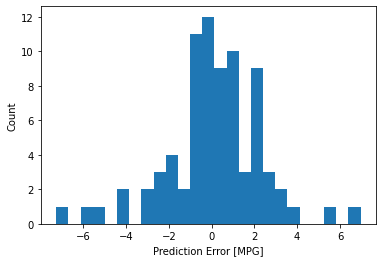

In [49]:
error = test_predictions - test_labels
plt.hist(error, bins =25)
plt.xlabel('Prediction Error [MPG]')
plt.ylabel('Count')

In [50]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


In [ ]:
test_result

In [ ]:
pd.DataFrame(test_result,index=['Mean_absolute_error'])